## Разведочный анализ

Подключитесь к базе данных PostgreSQL и выгрузите таблицу `exploratory`, сохранив ее в датафрейм. <br> <br>
Параметры для подключения следующие: хост – `******.******.ru`, порт – `5432`, имя базы данных – `db_ds_students`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`.

In [1]:
### YOUR CODE HERE ###
from sqlalchemy import create_engine
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=True)

sns.set_theme(style="ticks")

%matplotlib inline

In [2]:
# загружаем данные
engine = create_engine('postgresql://readonly:6hajV34RTQfmxhS@******.******.ru:5432/db_ds_students')
df = pd.read_sql_query('select * from "exploratory"',con=engine).astype('float')
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5
0,2.439930,-2.180961,33.468496,-1.927388,-5.321392
1,1.770580,-1.174880,0.989593,-1.139681,-2.080220
2,0.742817,-0.263483,0.168149,-0.332438,-0.195720
3,-1.510892,2.712571,-2.685643,2.058495,-4.098402
4,-0.483511,0.096511,-0.028703,0.168763,-0.046664


Проведем первичную разветку данных. Посмотрим, есть ли дублирующие или пропущенные значения. Для этого нам поможет библиотека `pandas_profiling`. 

In [3]:
primary_analysis = ProfileReport(df, title="Первичный разведочный анализ данных")
primary_analysis.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Из полученной первичной разведки анализа данных, мы видим, что нет дублирующих и пропущенных значений. Все признаки состоят из уникальных значений.  Высоко коррелируют между собой только признаки 2 и 4. Также видно, что признак 3 имеет одновременно высокое стандартное отклонение и низкий коэффициент вариации. Посмотрев на гисстограмму 3-го признака, мы можем увидеть подтверждения сильного разреженного распределения значений.

Постройте гистограммы распределения для каждой переменной. Поэксперементируйте с количеством "разбивок" (bins). Опишите распределение каждой переменной. В каких областях (пример: от нуля до 2 расположено примерно треть всех значений) сосредоточено больше значений, в каких меньше. 

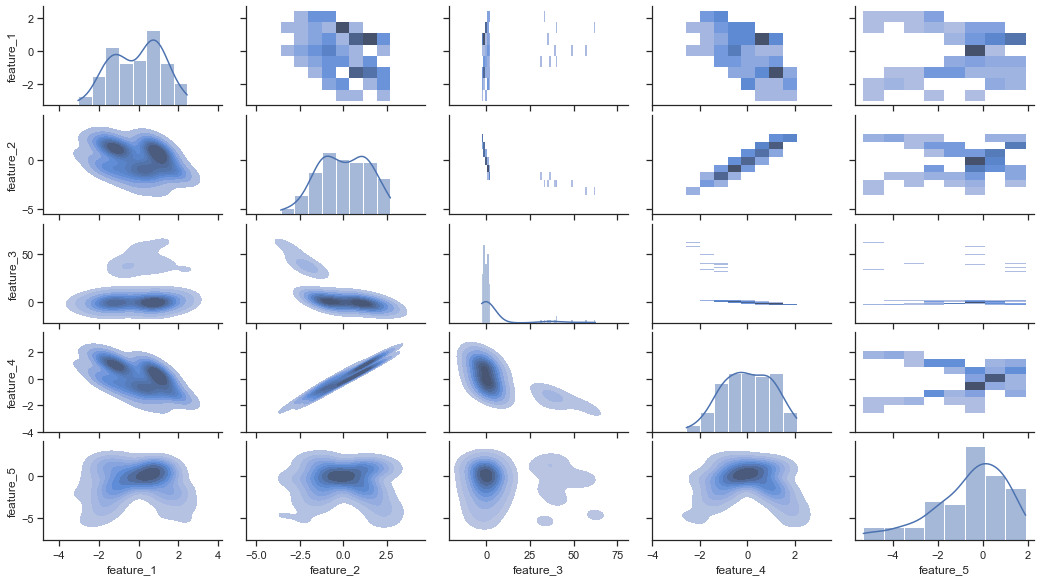

In [4]:
### YOUR CODE HERE ###
pg = sns.PairGrid(df)
pg.map_upper(sns.histplot)
pg.map_lower(sns.kdeplot, fill=True)
pg.map_diag(sns.histplot, kde=True)
plt.gcf().set_size_inches(15, 8)

Посмотрим на результат Pair Grid матрицу с гистограммами. Так, например, 1,2,4 признаки выглядят нормально распределёнными? хотя у 1 признака наблюдаются два локальных пика с провалом между ними, а 5 признак обладает ярко выраженной правой ассиметрией. Признак 3 стоит проанализировать отдельно.

Давайте те же сделаем это.

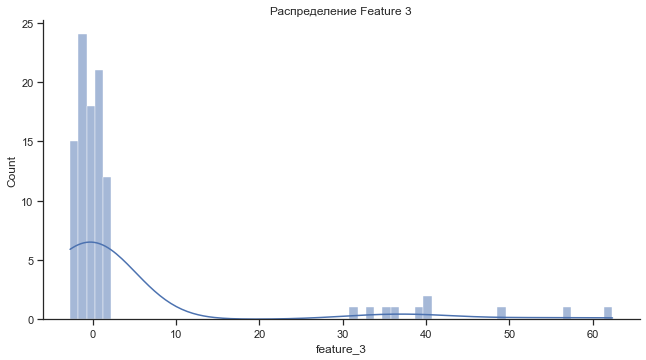

In [8]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.displot(df, x="feature_3", kde=True).set(title='Распределение Feature 3')
plt.gcf().set_size_inches(10, 5)

Большинство значений признака 3 лежит в диапазоне областей от -3 до 2, далее следует промежуток от 2 до 32, и далее имеется небольшое прореженное количество наблюдений.

Попробуем еще поэксперименти́ровать с признаком 3.

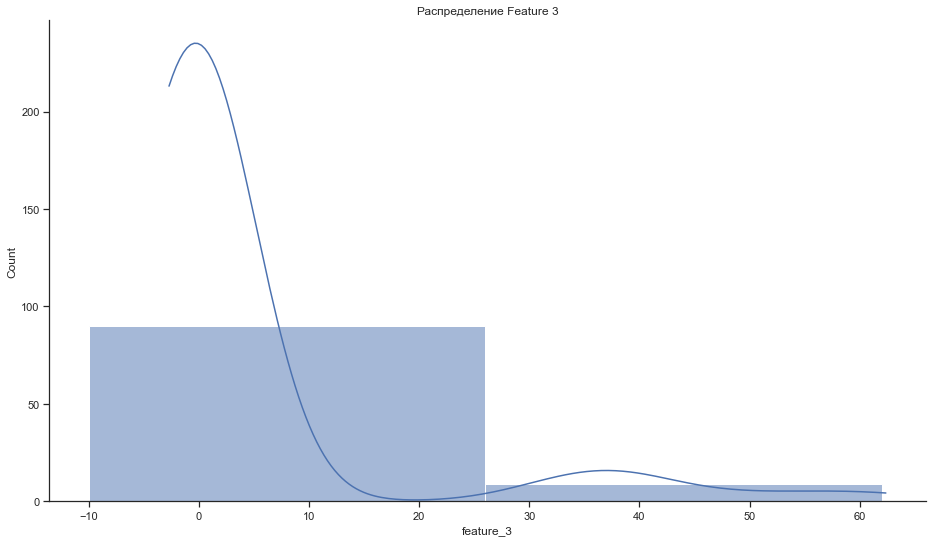

In [11]:
sns.displot(df, x="feature_3", bins = range(-10, 63, 36), kde=True).set(title='Распределение Feature 3')
plt.gcf().set_size_inches(15, 8)

Сведя гистограмму к двум диапазонам мы видим сильный перекос в количестве наблюдений. Если в дальнейшем использовать данный признак для построения моделей необходимо провести работу с данными для устранения неравномерности распределения (удалить пропуски, нормализовать значения) либо удалить наблюдения, которые в данном случае выглядят как выбросы.

Например вот так. При этом длина отфильтрованного датасета составляет 90% исходного.

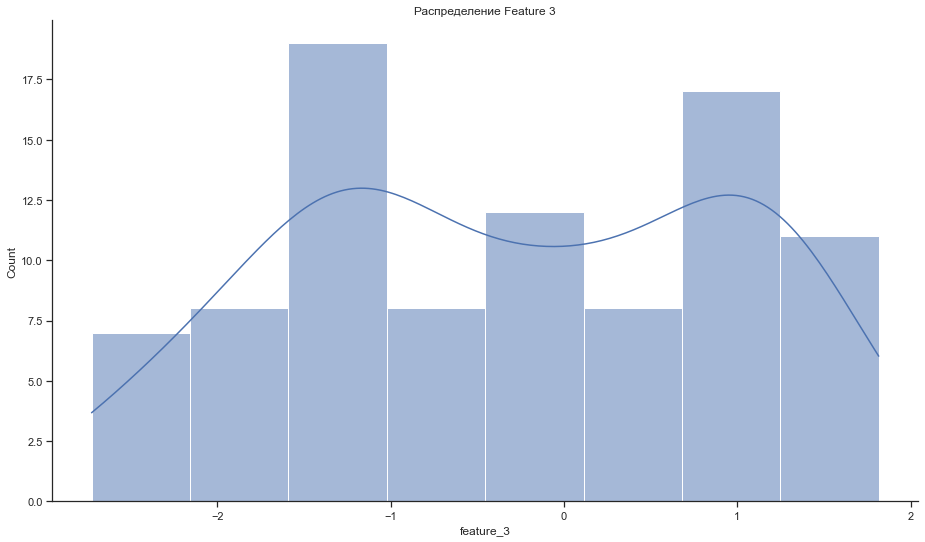

In [12]:
sns.displot(df[df['feature_3'] < 5], x="feature_3", kde=True).set(title='Распределение Feature 3')
plt.gcf().set_size_inches(15, 8)

Постройте ящик с усами для каждой переменной. Опишите распределение данных. Прокомментируйте наличие или отсутствие выбросов.

In [13]:
### YOUR CODE HERE ###
df.iplot(kind='box', boxpoints='outliers')

При построении боксплотов третий признак также ощутимо выделяется. Анализируя отдельно данный боксплот, можно сказать, что данные очень сильно разрежены вверх, при этом основная часть сконцентрированна в диапазоне [-3,2]. Видны выбросы по 3 признаку, по остальным выбросов нет. Второй и четвёртый признак нормально распределены, с медианой равной нулю. Признак 1 чуть смещён вверх по медиане, признак 5 смещён в область отрицательных значений относительно других признаков.

Допустим, мы хотим построить регрессионную модель по имеющимся данным и исследовать влияние остальных переменных на переменную `feature_4`. Постройте диаграммы рассеяния. Определите по графикам, какие независимые переменные имело бы смысл включить в модель регрессии?

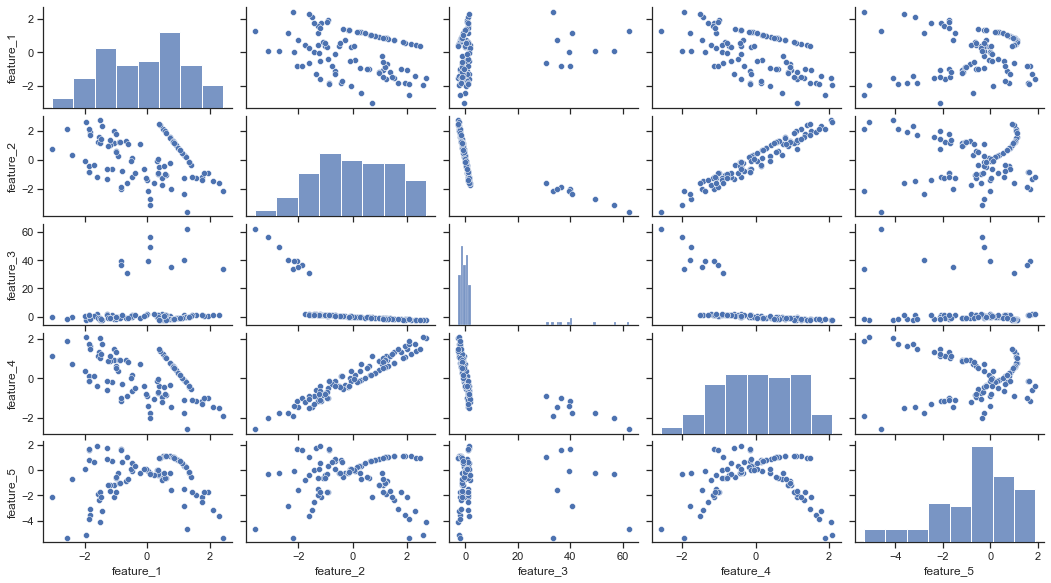

In [14]:
### YOUR CODE HERE ###
sns.pairplot(df)
plt.gcf().set_size_inches(15, 8)

По диаграммам рассеяния видно, как линейно связаны признаки 2 и 4. Также линейно связан и признак 3(за исключеним хвоста распределения).

Давайте, проверим еще на корреляцию.

<AxesSubplot:>

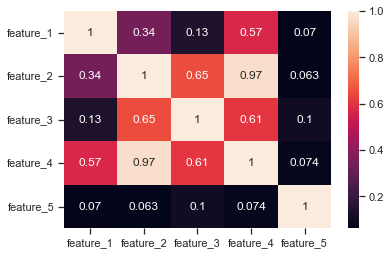

In [15]:
sns.heatmap(df.corr().apply(abs), annot = True)

Согласно таблице корреляций, 4 признак очень сильно связан со 2 признаком (что видно на графике), а также прослеживается связь с 1 и 3 признаком. Признак 5 практически не коррелирует с целевой переменной. Но так как у нас с признаком 3 есть значительные проблемы, давайте подкорректируем(отсечем хвост) его и выведем новую корреляцию.

<AxesSubplot:>

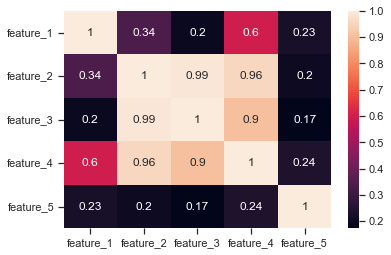

In [16]:
sns.heatmap(df[df['feature_3'] < 5].corr().apply(abs), annot = True)

После отсечения хвоста распределения признака 3, его связь с целевой переменной возросла до 0,9. Тем не менее, теперь признак 3 очень сильно коррелирует с признаком 2. Таким образом, мы можем использовать для регрессионой модели либо признак 2 либо признак 3 (с отсечением значений) либо попарно признаки 1 - 2 и 1 - 3.